In [1]:
# Declaring types helps the compiler speed things up.
function transmat(n::Int64, p::Float64, q::Float64)
    if n <= 1
        error("n needs to be bigger than 1 (transmat)")
    end
    # Define P0 outside of a for loop.  Variables defined in
    # for loops are local and cannot be returned.
    P0 = [p 1.0-p; 1.0-q q]'
    if n > 2
        for i = 2:(n-1)
            Pnew = zeros(i+1,i+1)
            z0 = zeros(i+1,i+1)
            z1 = zeros(i+1,i+1)
            z2 = zeros(i+1,i+1)
            z3 = zeros(i+1,i+1)
            # Matrices are indexed using square brackets. 
            # Otherwise, just like Matlab.
            z0[1:i, 1:i] = P0
            z1[1:i, 2:(i+1)] = P0
            z2[2:(i+1),1:i] = P0
            z3[2:(i+1),2:(i+1)] = P0
            mat_sum = p*z0+(1-p)*z1+(1-q)*z2+q*z3
            Pnew[1,:] = mat_sum[1,:]
            Pnew[i+1,:] = mat_sum[i+1,:]
            Pnew[2:i,:] = 0.5*mat_sum[2:i,:]
            # deepcopy ensures that you are not using a pointer.
            # Matrices are pass by reference, and setting one matrix
            # equal to another can be like pointing to the original
            # matrix.
            P0 = deepcopy(Pnew)
        end 
    end
    return P0
end

transmat (generic function with 1 method)

In [2]:
# This is like a fortran structured array.
# The fields cannot be modified (in that you cannot
# add fields later).

# Note that I am making use of unicode characters.
# To me, it reads better.
type params_t
    β::Float64
    γ_π::Float64
    γ_y::Float64
    κ::Float64
    π̄::Float64
end
# This is how you construct a params_t object.
params = params_t(0.99,1.5,0.25,0.05,1.005)

params_t(0.99, 1.5, 0.25, 0.05, 1.005)

In [3]:
# User-defined types can be declared (see params_t).
function solve_case(η::Array{Float64,1}, P::Array{Float64,2}, params::params_t, ns::Int64, js::Int64)
    # Fields of user-defined types are called with dot notation.
    β = params.β
    γ_π = params.γ_π
    γ_y = params.γ_y
    κ = params.κ
    π̄ = params.π̄
    R_ss = log(π̄/β)
    
    I_ns = eye(ns)
    H0 = zeros(2*ns,2*ns)
    H1 = ones(ns,ns)
    I_js = eye(js)
    I_jps = eye(ns-js)
    
    H0 = zeros(2*ns,2*ns)
    H0[1:js,1:js] = I_js
    H0[(js+1):ns,(js+1):ns] = (1.0+γ_y)*I_jps
    H0[(js+1):ns,(ns+js+1):end] = γ_π*I_jps
    H0[(ns+1):end,1:ns] = -κ*I_ns
    H0[(ns+1):end,(ns+1):end] = I_ns
    H1 = zeros(2*ns,2*ns)
    H1[1:ns,1:ns] = P
    H1[1:ns,(ns+1):end] = P
    H1[(ns+1):end,(ns+1):end] = β*P
    
    A = H0-H1
    B = zeros(2*ns)
    B[1:js] = R_ss+η[1:js]
    B[(js+1):ns] = η[(js+1):ns]
    xx = A\B
    yy = xx[1:ns]
    dp = xx[(ns+1):end]
    notr = γ_π*dp+γ_y*yy
    # If you want a function to apply to all elements of an array,
    # Julia generally requires dot notation.  Here, max.(scalar,vector)
    # means that we are taking the max of the the scalar and each element of
    # the vector and returning the maximum value, element by element. So,
    # the return value is a vector.  If we did max(scalar, maximum(vector)),
    # we would get the max of the maximum value of the vector and the scalar.
    nomr = max.(-R_ss,notr)
    
    # Parentheses around return values means we are returning a tuple.
    return (yy,dp,notr,nomr)  
end

solve_case (generic function with 1 method)

In [4]:
function solve_model(η::Array{Float64,1},P::Array{Float64,2},params::params_t,ns::Int64)
    Rss = log(params.π̄/params.β)
    solution_type = -1
    # We have to define these variables outside of for loop.
    # Variables defined in for loops are local.
    (yy,dp,notr,nomr) = solve_case(η,P,params,ns,0)
    if all(notr .>= -Rss)
        solution_type = 0
    else
        for j = 1:ns
            if solution_type == -1
                (yy,dp,notr,nomr) = solve_case(η,P,params,ns,j)
            end
            if (all(notr[1:j] .<= -Rss) & all(notr[(j+1):end] .>= -Rss))
                solution_type = j
            end
        end
    end
    return (solution_type,yy,dp,notr,nomr) 
end


solve_model (generic function with 1 method)

In [5]:
p   = 0.99
q   = 0.85
# Note that 51 is different that 51.0. This is similar to Fortran. 
# Here, 51 means that ns is an integer.
ns  = 51
P   = transmat(ns,p,p)
Q   = transmat(ns,q,q)
σ_η = 0.0035
ψ   = sqrt(ns-1.0)*σ_η
# This is an example of converge.  linspace returns a special type.
# For me, it is easier to just use arrays of Float64s.
η   = Array{Float64,1}(linspace(-ψ,ψ,ns))
ar_lim = 2.0
P̃ = zeros(ns,ns)
for i = 1:ns
    if abs(η[i]) <= ar_lim*σ_η 
        P̃[i,:] = P[i,:]
    else
        P̃[i,:] = Q[i,:]
    end
end

In [6]:
(solution_type,yy,dp,notr,nomr) = solve_model(η,P̃,params,ns)
(yyu,dpu,notru,nomru) = solve_case(η,P̃,params,ns,0)
(solution_type1,yy1,dp1,notr1,nomr1) = solve_model(η,P,params,ns)
print(solution_type,solution_type1)

14-1

In [7]:
# Interface to matplotlib
using PyPlot

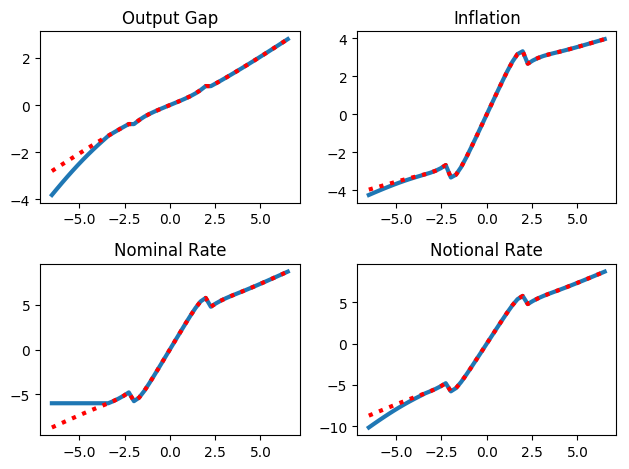

/Users/ben/Library/Python/2.7/lib/python/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [9]:
# Julia does not play well with redefining 'end'
# Note that a single quote (string literal) is different than a double quote (character vector)
# Rather that axs[,].plot, use axs[,][:plot]. Similar for other fields
# Finally, no need to do anything if you want to break a line, so long as it is within
# the parentheses for an argument list.
startval = 3
endval = ns+1-3
fig1, axs1 = subplots(2, 2, tight_layout=true)
axs1[1,1][:plot](η[startval:endval]/σ_η,100*yy[startval:endval],linewidth=3,label="Constrained") 
axs1[1,1][:plot](η[startval:endval]/σ_η,100*yyu[startval:endval],"r:",linewidth=3,
               label="Unconstrained") 
axs1[1,1][:set_title]("Output Gap")
axs1[1,2][:plot](η[startval:endval]/σ_η,400*dp[startval:endval],linewidth=3,label="Constrained")
axs1[1,2][:plot](η[startval:endval]/σ_η,400*dpu[startval:endval],"r:",linewidth=3,
               label="Unconstrained")
axs1[1,2][:set_title]("Inflation")
axs1[2,1][:plot](η[startval:endval]/σ_η,400*nomr[startval:endval],linewidth=3,label="Constrained")
axs1[2,1][:plot](η[startval:endval]/σ_η,400*notru[startval:endval],"r:",linewidth=3,
                 label="Unconstrained")
axs1[2,1][:set_title]("Nominal Rate")
axs1[2,2][:plot](η[startval:endval]/σ_η,400*notr[startval:endval],linewidth=3,label="Constrained") 
axs1[2,2][:plot](η[startval:endval]/σ_η,400*notru[startval:endval],"r:",linewidth=3,
               label="Unconstrained") 
axs1[2,2][:set_title]("Notional Rate")
show()

In [10]:
#generate Heat Maps
Nrow = 100
Ncol = 100
pvec = Array{Float64,1}(linspace(0.95,0.995,Ncol))
η_ψ = Array{Float64,1}(linspace(0.005,0.035,Nrow))
ρ_η = 2*pvec-1
# Declar a matrix of integers
sol = Array{Int64,2}(Nrow,Ncol) * 0
sol1 = Array{Int64,2}(Nrow,Ncol) * 0

for i = 1:Ncol
    for j = 1:Ncol
        ψ = η_ψ[j]
        p = pvec[i]
        η = Array{Float64,1}(linspace(-ψ,ψ,ns))
        P = transmat(ns,p,p)
        for k = 1:ns
            if abs(η[k]) <= ar_lim*σ_η
                P̃[k,:] = P[k,:]
            else
                P̃[k,:] = Q[k,:]
            end
        end
        (sol[j,i],yy,dp,notr,nomr) = solve_model(η,P̃,params,ns)
        (sol1[j,i],yy,dp,notr,nomr) = solve_model(η,P,params,ns)
    end
end

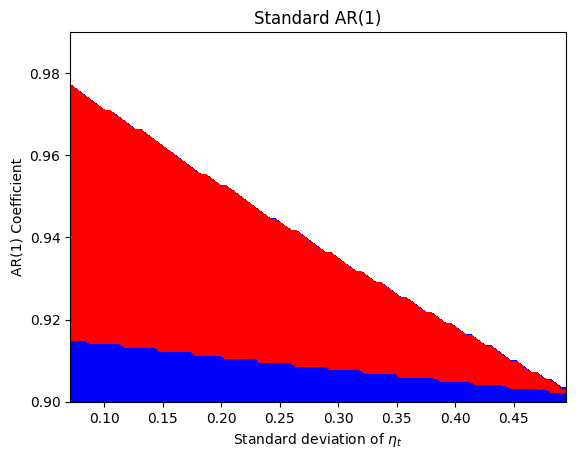

PyObject <matplotlib.text.Text object at 0x122a6d250>

In [11]:
fig3, axs3 = subplots(1, 1)
pos = axs3[:contourf](100.0*η_ψ/sqrt(ns-1), ρ_η, sol1,extend="neither",
                    levels=[-1.5,-0.5,0.5,ns],colors=("w","b","r"))
# Use the L"" notation to use latex in a label.
axs3[:set_xlabel](L"Standard deviation of $\eta_t$")
axs3[:set_ylabel]("AR(1) Coefficient")
axs3[:set_title]("Standard AR(1)")

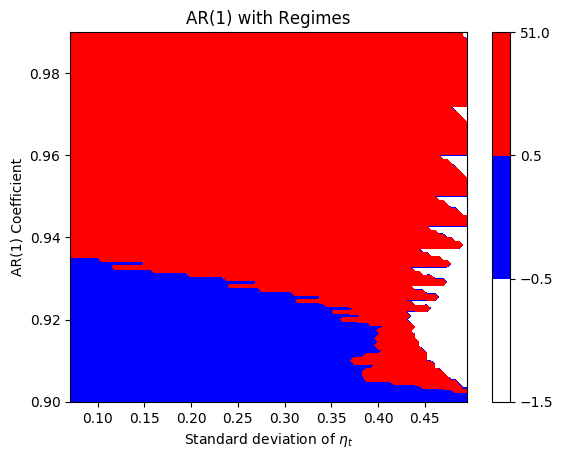

PyObject <matplotlib.colorbar.Colorbar object at 0x122f17890>

In [12]:
fig2, axs2 = subplots(1, 1)
fig2[:colorbar](pos,ax=axs3)

pos = axs2[:contourf](100.0*η_ψ/sqrt(ns-1), ρ_η, sol,extend="neither",
                    levels=[-1.5,-0.5,0.5,ns],colors=("w","b","r"))
axs2[:set_xlabel](L"Standard deviation of $\eta_t$")
axs2[:set_ylabel]("AR(1) Coefficient")
axs2[:set_title]("AR(1) with Regimes")
fig2[:colorbar](pos,ax=axs2)